In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import seaborn as sns

from global_config import config

data_dir      = config.get_property('covid_fb')
geo_dir       = config.get_property('geo_dir')
data_dir_mnps = config.get_property('data_dir_col')
results_dir   = config.get_property('results_dir')
agglomeration_df = pd.read_csv(os.path.join(data_dir_mnps, 'administrative_division_col_2018.csv')).set_index('poly_id')


ValueError: Configuration variable "data_dir_covid", was not found. Please add it

In [38]:
# Loads the rt
df_rt = pd.read_csv('../rt_merged_all.csv',  parse_dates = ['date'])
df_rt['poly_id'] = df_rt.region.apply(lambda s: s.lower().replace('í','i').replace('ó','o').replace('á','a').replace('é','e').replace('ñ','n').replace(' ','_'))
df_rt.sample(10)

,Unnamed: 0,date,median,mean,lower_90,lower_50,lower_20,upper_20,upper_50,upper_90,region,region_id,poly_id
5685,193,2020-10-05,0.960707,0.959719,0.914176,0.944137,0.954818,0.966864,0.977064,0.999115,Usme,5,usme
3399,49,2020-05-05,1.118819,1.119225,1.058735,1.096206,1.109459,1.127725,1.142901,1.181255,Rafael Uribe Uribe,18,rafael_uribe_uribe
709,104,2020-07-03,1.052235,1.048294,0.988438,1.027727,1.042692,1.059307,1.071985,1.096483,Bosa,7,bosa
3415,65,2020-05-21,1.142872,1.144528,1.087302,1.121188,1.134933,1.151273,1.166252,1.205996,Rafael Uribe Uribe,18,rafael_uribe_uribe
5032,158,2020-08-25,0.926693,0.926315,0.872631,0.907522,0.919362,0.934143,0.947327,0.976659,Tunjuelito,6,tunjuelito
2790,38,2020-05-05,1.275101,1.279801,1.202280,1.244225,1.263006,1.287604,1.311640,1.374624,Los Mártires,14,los_martires
5756,264,2020-12-15,1.078069,1.078677,1.038086,1.060798,1.071201,1.084524,1.095077,1.122971,Usme,5,usme
4419,163,2020-08-23,0.842996,0.843463,0.796882,0.823673,0.835873,0.850154,0.862428,0.893125,Suba,11,suba
2258,114,2020-07-04,1.104575,1.105465,1.057831,1.087147,1.098536,1.111486,1.123134,1.154806,Kennedy,8,kennedy
3132,86,2020-06-12,1.226749,1.233829,1.162622,1.199400,1.215739,1.238791,1.260748,1.328120,Puente Aranda,16,puente_aranda


In [35]:

df = pd.read_csv('movement_fb_locality/movement.csv', parse_dates = ['date_time'])
df.start_poly_id = df.start_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))
df.end_poly_id = df.end_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))

# Creates type
df["movement_type"] = "External"
df.loc[df.start_poly_id == df.end_poly_id,"movement_type"] = "Internal"
df.sample(10)


# Consolidates dataframe
d1 = df.loc[df.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

d2 = df.loc[df.movement_type == "External",['date_time','end_poly_id', 'movement','movement_type']]
d2.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

d3 = df.loc[df.movement_type == "Internal",['date_time','end_poly_id', 'movement','movement_type']]
d3.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

df_movement = pd.concat((d1,d2,d3), ignore_index = True)
df_movement = df_movement.groupby(['date_time','poly_id','movement_type']).sum().reset_index()
print(df_movement.poly_id.unique())
df_movement

['barrios_unidos' 'bosa' 'chapinero' 'ciudad_bolivar' 'engativa'
 'fontibon' 'kennedy' 'los_martires' 'puente_aranda' 'rafael_uribe_uribe'
 'san_cristobal' 'santa_fe' 'suba' 'teusaquillo' 'tunjuelito' 'usaquen'
 'usme']


,date_time,poly_id,movement_type,movement
0,2020-04-12,barrios_unidos,External,2265
1,2020-04-12,barrios_unidos,Internal,28117
2,2020-04-12,bosa,External,6562
3,2020-04-12,bosa,Internal,184756
4,2020-04-12,chapinero,External,3310
...,...,...,...,...
8393,2020-12-22,tunjuelito,Internal,15514
8394,2020-12-22,usaquen,External,18440
8395,2020-12-22,usaquen,Internal,44766
8396,2020-12-22,usme,External,4412


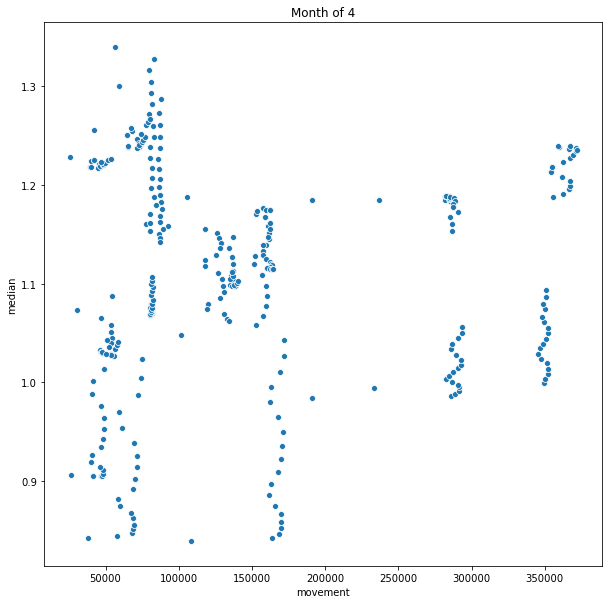

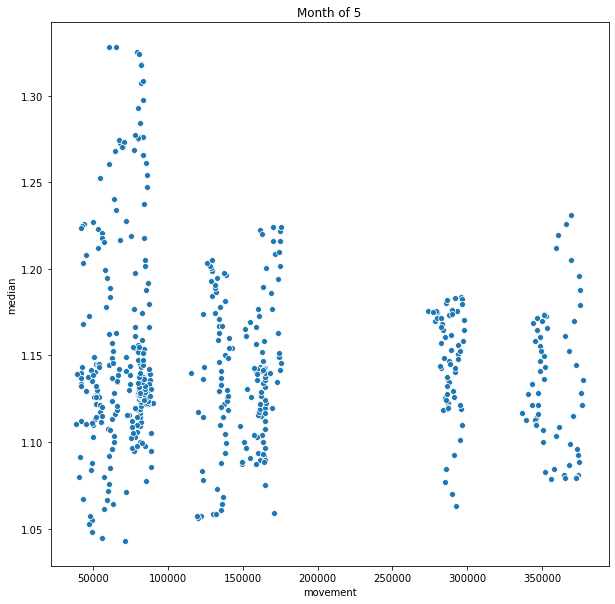

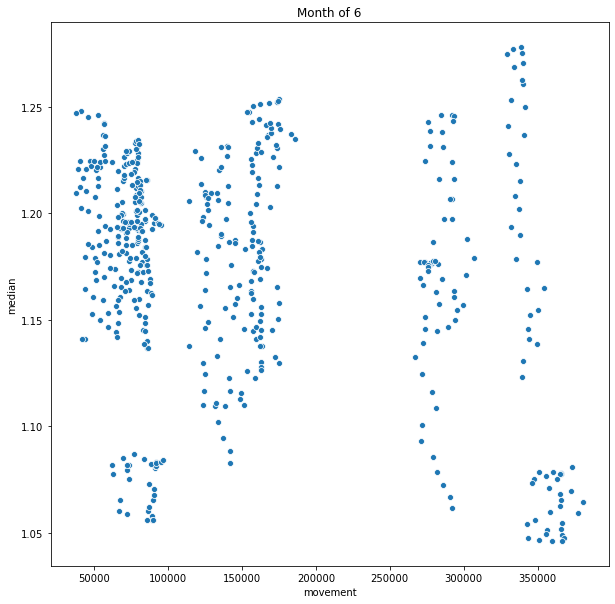

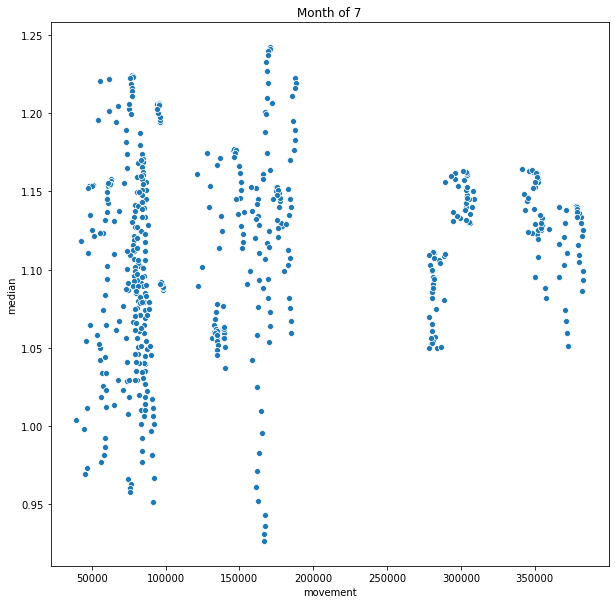

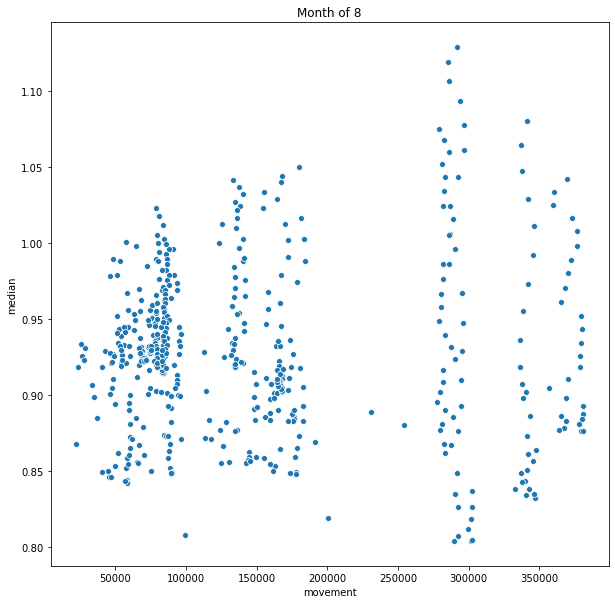

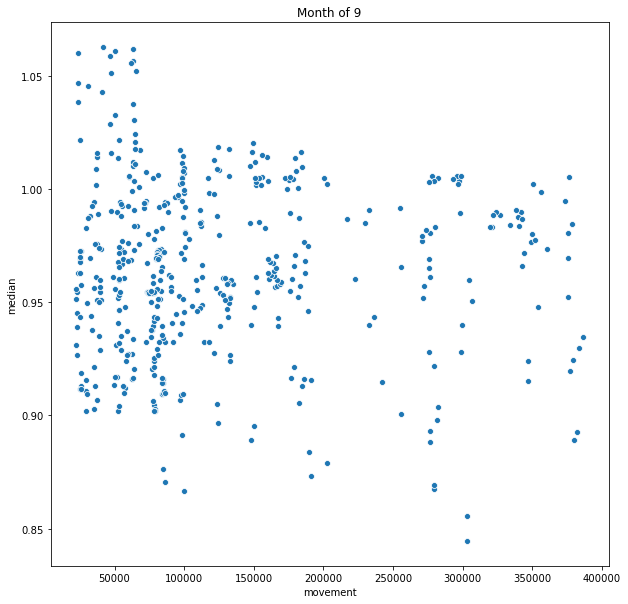

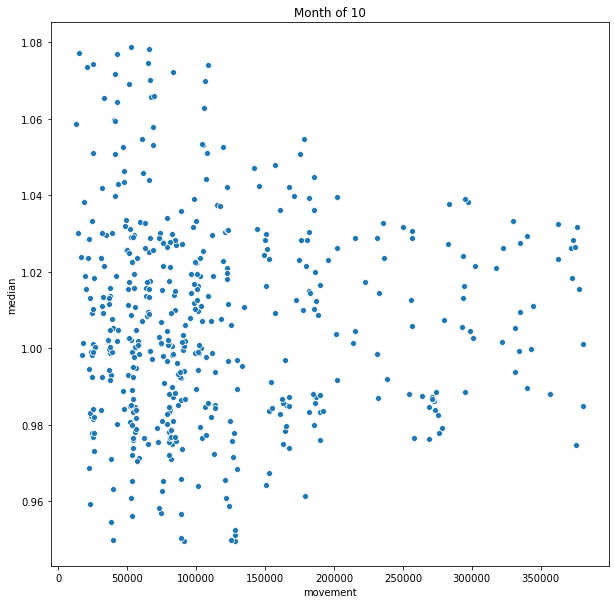

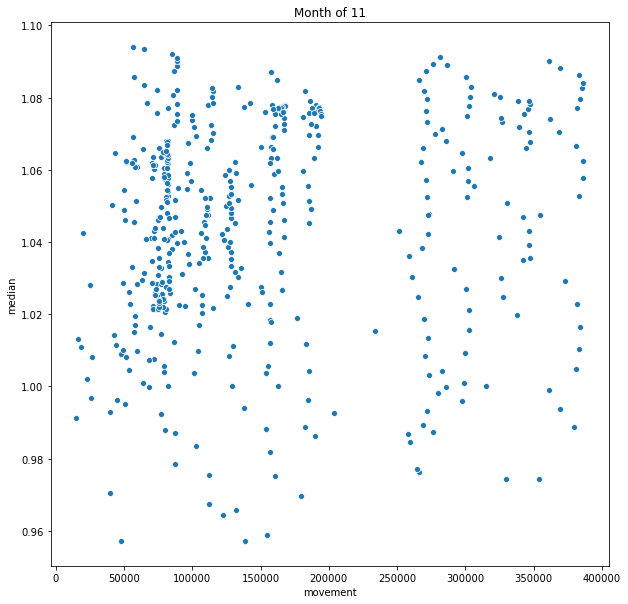

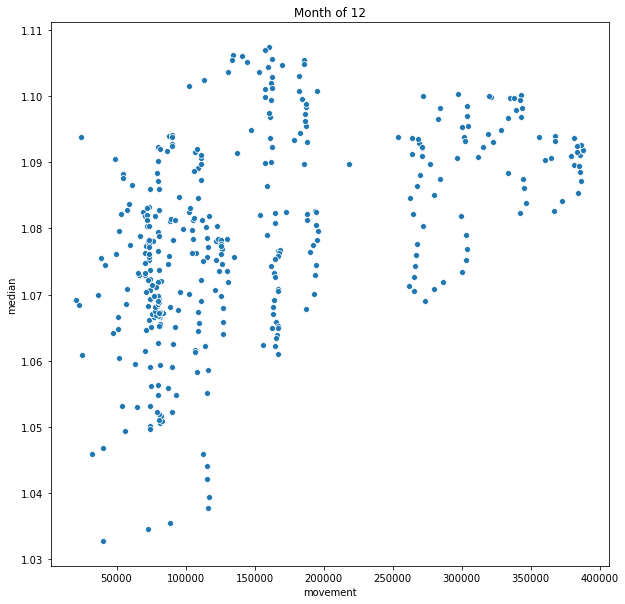

In [53]:
df_move_plot = df_movement[['date_time','poly_id','movement']].groupby(['date_time','poly_id']).sum().reset_index()
df_mov_rt = df_move_plot.merge(df_rt[["date","poly_id","median"]].rename(columns = {"date":"date_time"}), on = ["date_time","poly_id"])

df_mov_rt['month'] = df_mov_rt.date_time.apply(lambda s: s.month)

for m in df_mov_rt['month'].unique():
    df_temp = df_mov_rt[df_mov_rt.month == m].copy()
    fig=plt.figure(figsize=(10, 10), facecolor='w')
    ax = sns.scatterplot(data = df_temp, x = 'movement', y = "median")
    ax.set_title(f"Month of {m}")

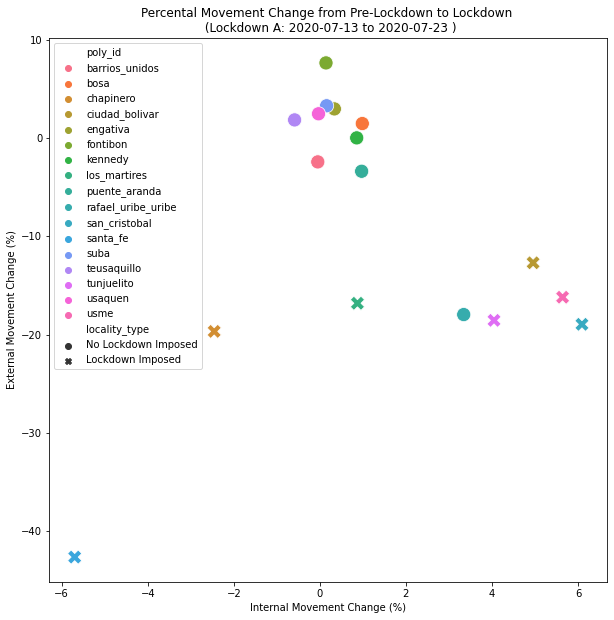

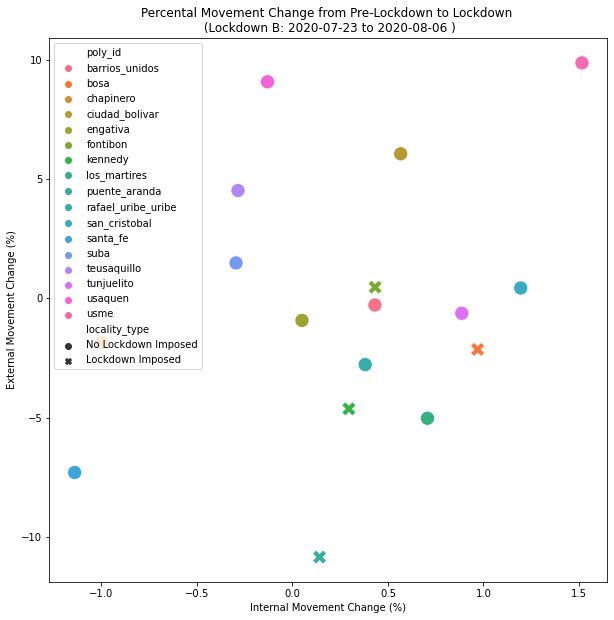

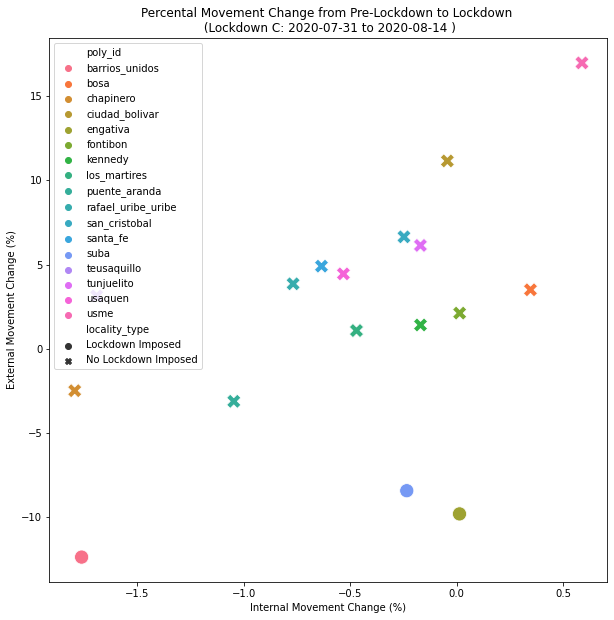

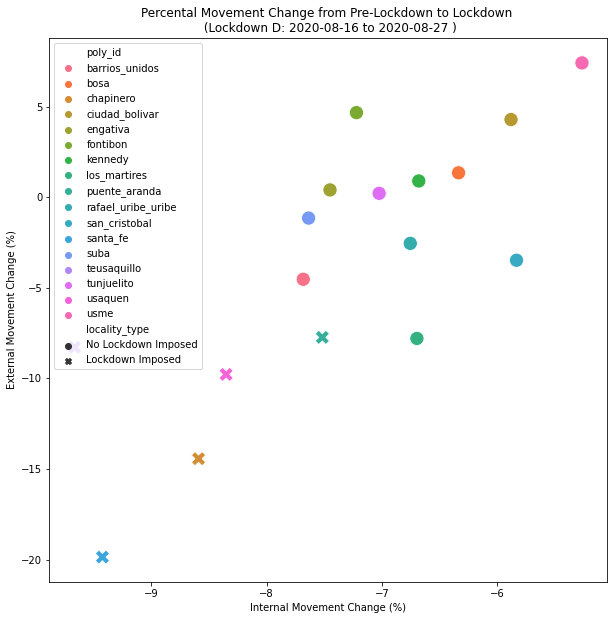

In [54]:
# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab = "Lockdown Imposed"

# PreLockdown
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end = pd.to_datetime("2020-07-13")

lockdowns = []
lockdowns.append({"code":"A",
                  "start_date":"2020-07-13", 
                  "end_date":"2020-07-23", 
                  "places":["chapinero", 
                            "los_martires", 
                            "san_cristobal", 
                            "tunjuelito", 
                            "rafel_uribe_uribe", 
                            "ciudad_bolivar", 
                            "santa_fe",
                            "usme"]})


lockdowns.append({"code":"B",
                  "start_date":"2020-07-23", 
                  "end_date":"2020-08-06", 
                  "places":["bosa", 
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code":"C",
                  "start_date":"2020-07-31", 
                  "end_date":"2020-08-14", 
                  "places":["suba", 
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code":"D",
                  "start_date":"2020-08-16", 
                  "end_date":"2020-08-27", 
                  "places":["usaquen", 
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


for lock in lockdowns:

    duration = (pd.to_datetime(lock['end_date']) - pd.to_datetime(lock['start_date'])).days

    
    lockdown_start = pd.to_datetime(lock['start_date'])
    lockdown_end = pd.to_datetime(lock['end_date'])

    # Filter by date
    df_temp = df_movement.copy()
    
    df_temp['moment'] = None
    
    # Assigns moments
    df_temp.loc[(df_movement.date_time <= pre_lockdown_end) 
                & (df_movement.date_time >= pre_lockdown_start),'moment'] = "Pre-Lockdown"
    df_temp.loc[(df_movement.date_time <= lockdown_end) 
                & (df_movement.date_time >= lockdown_start),'moment'] = "Lockdown"

    # Filters
    df_temp = df_temp[~df_temp.moment.isna()].copy()
    

    # Then by week
    df_temp = df_temp[["poly_id","moment","movement_type","movement"]].groupby(["poly_id","moment","movement_type"]).mean().reset_index()
    df_temp = df_temp.pivot_table(index = ['poly_id'], columns=["moment","movement_type"], values = ['movement']).reset_index()
    #df_temp.columns = ["poly_id",'moment',"external_movement","internal_movement"]
    
    df_temp['external_change'] = 100*(df_temp.movement.Lockdown.External -  df_temp.movement["Pre-Lockdown"].External)/df_temp.movement["Pre-Lockdown"].External
    df_temp['internal_change'] = 100*(df_temp.movement.Lockdown.Internal -  df_temp.movement["Pre-Lockdown"].Internal)/df_temp.movement["Pre-Lockdown"].Internal
    df_temp['all_change'] = 100*((df_temp.movement.Lockdown.Internal + df_temp.movement.Lockdown.External) - (df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External))/(df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External)
    df_temp['locality_type'] =  no_lock_lab
    df_temp.loc[df_temp.poly_id.isin(lock['places']), 'locality_type'] = lock_lab
    
    fig=plt.figure(figsize=(10, 10), facecolor='w')
    ax = sns.scatterplot(data = df_temp, 
                    x = "internal_change", 
                    y = "external_change", 
                    hue = "poly_id", 
                    style = "locality_type",
                    s = 200)

    ax.set(xlabel='Internal Movement Change (%)', ylabel='External Movement Change (%)')
    ax.set_title(f"Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown {lock['code']}: {lock['start_date']} to {lock['end_date']} )")
    
    
    # Saves the dataframe
    
    df_temp.columns = ["_".join(col).lower().replace("__","") for col in df_temp.columns.values]
    df_temp.to_csv(f'../data/movement_clean/internal_external_lockdown_{lock["code"]}.csv')

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

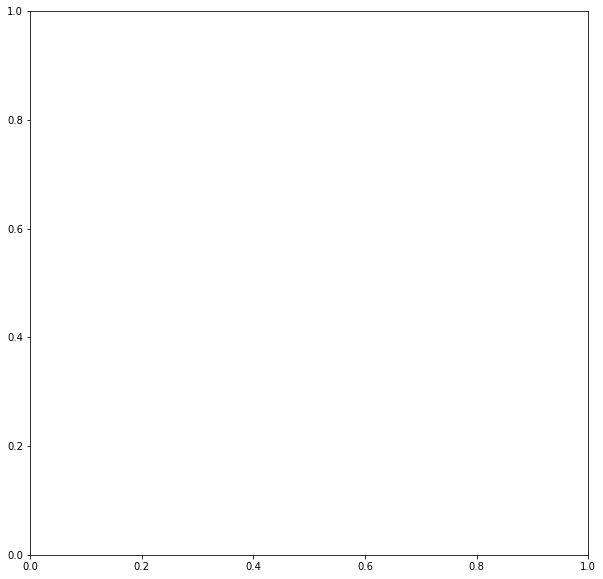

In [96]:
s = 30
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

df_plot_lock = df_temp[df_temp.locality_type == lock_lab]
df_plot_no_lock = df_temp[df_temp.locality_type == no_lock_lab]

ax1.scatter(df_plot_lock.internal_change, df_plot_lock.external_change, color = df_plot_lock.poly_id, s=s, marker="s", label= lock_lab)
ax1.scatter(df_plot_no_lock.internal_change, df_plot_no_lock.external_change, s=s, c='r', marker="o", label= no_lock_lab)
plt.legend(loc='upper left');
plt.show()

Text(0.5, 1.0, 'Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown: 2020-07-13 to 2020-07-23 )')

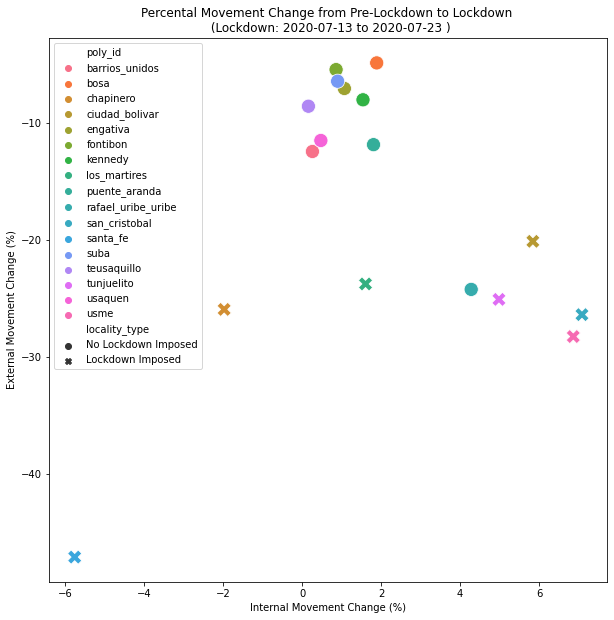

In [97]:
fig=plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = df_temp, 
                x = "internal_change", 
                y = "external_change", 
                hue = "poly_id", 
                style = "locality_type",
                s = 200)

ax.set(xlabel='Internal Movement Change (%)', ylabel='External Movement Change (%)')
ax.set_title(f"Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown: {lock['start_date']} to {lock['end_date']} )")